# **Task 2**
# **Original AlexNet Model**

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [19]:
## transformations
BATCH_SIZE = 64
train_transform = transforms.Compose([
                           transforms.RandomCrop(32, padding=2),
                           transforms.ToTensor()
                       ])

test_transform = transforms.Compose([
                           transforms.ToTensor()
                       ])

## download and load training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)


## Split train data into train data and validation data
trainset, validset = torch.utils.data.random_split(trainset, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, 
                                        shuffle=False, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


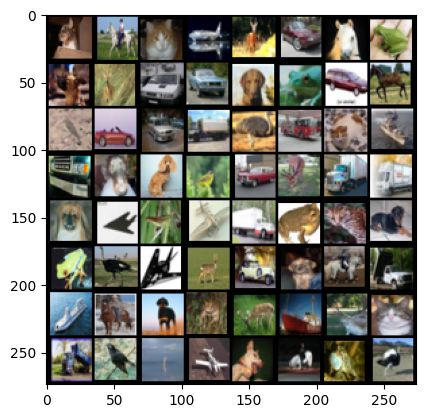

In [20]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.__next__()

## show images
imshow(torchvision.utils.make_grid(images))

In [21]:
# Checking the dataset
print('Training Set:\n')
for images, labels in trainloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break


Training Set:

Image batch dimensions: torch.Size([64, 3, 32, 32])
Image label dimensions: torch.Size([64])


In [22]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2), 
            nn.MaxPool2d(2),  
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        ## Dropouts are added for regularizaiton
        self.classifier = nn.Sequential(
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x1 = x.view(x.shape[0], -1) ## Flatening the data 
        x = self.classifier(x1)
        return x

In [23]:
## checking the model if it is working fine
model = AlexNet()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([64, 3, 32, 32])
torch.Size([64, 10])


In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [25]:
test_acc = 0.0
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

# **Initial Accuracy**

In [26]:
test_acc = 0.0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 10.02


# **Training Model**

In [27]:
def train(model, loader, optimizer, criterion, device):
  train_running_loss = 0.0
  train_acc = 0.0

  model = model.train()

  ## training step
  for i, (images, labels) in enumerate(loader):
      
      images = images.to(device)
      labels = labels.to(device)

      ## forward + backprop + loss
      logits = model(images)
      loss = criterion(logits, labels)
      loss.backward()

      train_running_loss += loss.detach().item()
      train_acc += get_accuracy(logits, labels, BATCH_SIZE)

  return train_running_loss / len(loader), train_acc / len(loader)


In [28]:
def valid(model, loader, criterion, device):
  valid_running_loss = 0.0
  valid_acc = 0.0

  model = model.eval()
  with torch.no_grad():

    for i, (images, labels) in enumerate(loader):
        
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits, labels)

        valid_running_loss += loss.detach().item()
        valid_acc += get_accuracy(logits, labels, BATCH_SIZE)

  return valid_running_loss / len(loader), valid_acc / len(loader)


In [29]:
best_valid_loss = float('inf') # initialization
learning_rate = 0.0001
num_epochs = 50
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AlexNet()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

for epoch in range(num_epochs):

    # Trainig loss calculation
    train_loss, train_acc = train(model, trainloader, optimizer, criterion, device) 
    # Validation loss calculation
    valid_loss, valid_acc = valid(model, validloader, criterion, device)
    ## looking for the model that gives me the best validation accuracy
    if valid_loss < best_valid_loss: 
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')
    
    model.eval()
    print('Epoch: %d |' \
          %(epoch))     
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2f}%')   

Epoch: 0 |
	Train Loss: 2.303 | Train Acc: 10.04%
	 Val. Loss: 2.303 |  Val. Acc: 9.79%
Epoch: 1 |
	Train Loss: 2.303 | Train Acc: 10.04%
	 Val. Loss: 2.303 |  Val. Acc: 9.79%
Epoch: 2 |
	Train Loss: 2.303 | Train Acc: 10.04%
	 Val. Loss: 2.303 |  Val. Acc: 9.79%
Epoch: 3 |
	Train Loss: 2.303 | Train Acc: 10.04%
	 Val. Loss: 2.303 |  Val. Acc: 9.79%
Epoch: 4 |
	Train Loss: 2.303 | Train Acc: 10.04%
	 Val. Loss: 2.303 |  Val. Acc: 9.79%
Epoch: 5 |
	Train Loss: 2.303 | Train Acc: 10.04%
	 Val. Loss: 2.303 |  Val. Acc: 9.79%
Epoch: 6 |
	Train Loss: 2.303 | Train Acc: 10.04%
	 Val. Loss: 2.303 |  Val. Acc: 9.79%
Epoch: 7 |
	Train Loss: 2.303 | Train Acc: 10.04%
	 Val. Loss: 2.303 |  Val. Acc: 9.79%
Epoch: 8 |
	Train Loss: 2.303 | Train Acc: 10.04%
	 Val. Loss: 2.303 |  Val. Acc: 9.79%
Epoch: 9 |
	Train Loss: 2.303 | Train Acc: 10.04%
	 Val. Loss: 2.303 |  Val. Acc: 9.79%
Epoch: 10 |
	Train Loss: 2.303 | Train Acc: 10.04%
	 Val. Loss: 2.303 |  Val. Acc: 9.79%
Epoch: 11 |
	Train Loss: 2.303 

# **Test Accuracy**

In [30]:
model.load_state_dict(torch.load('best-model.pt'))
test_acc = 0.0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 10.02
